<a href="https://colab.research.google.com/github/iadr/simulacion_2019/blob/master/Laboratorio_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cadenas de Markov Monte Carlo 


El laboratorio consta de 7 preguntas entre las celdas de código, verifique que respondió todas. 




*El presente Laboratorio está basado en el capítulo 3 del libro: Probabilistic Programming and Bayesian Methods for Hackers.*


## Algorithms to perform MCMC

Existe una gran familia de algoritmos que ejecutan Cadenas de Markov Monte Carlo (MCMC). La mayoría de ellos puede ser expresados como siguien: 


1. Inicio en posición actual. 
2. Se propone mover a una nueva posición (investigar un punto cercano). 
3. Aceptar/Rechazar la nueva posición de los datos y distribuciones previas (priors). 
4. 
  - Si acepta: Mover a la nueva posición. Regresar al paso 1. 
  - Si no: No moverse a la nueva posición. Regresar al paso 1. 
5. Luego de un gran número de iteraciones, retornar todas las posiciones aceptadas. 

Como se observa en el pseudocódigo, solo interesa la posición actual (las nuevas posiciones solo son investigadas cerca de esta posición). Esta falta de memoria  (memorylessness) se llama propiedad de Markov.

In [0]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
import pymc3 as pm
import theano.tensor as T
import scipy
from scipy import optimize



## MCMC para descubrir clusters de datos.  



[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


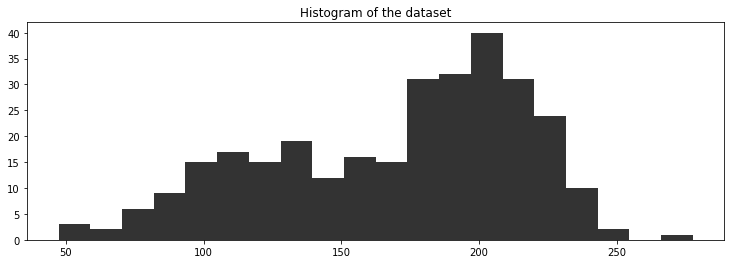

In [4]:
figsize(12.5, 4)
data = np.loadtxt("mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")



En el gráfico se observa que los datos (posterior) podrían seguir dos guassianas, por lo que MCMC buscará por medio de muestras y supuestos (priors) cuales son los parámetros de cada distribución. 



En la siguiente sección se utilizará la librería pyMC3. 

1. Primero creando un modelo (pm.Model()) con el nombre de model. 

2. En el modelo, a priori, no sabemos la probabilidad de asignar un dato al cluster 1 o al cluster 0, por lo que se usará una distribución uniforme (0,1). Se llamará $p_1$ la probabilidad de pertenecer al cluster 1, y por lo tanto pertecer al cluster 2 será:  $p_2 = 1 - p_1$ 



In [5]:

with pm.Model() as model:
    #Probabilidad de pertenecer al primer cluster Prior uniforme sobre (0,1).
    p1 = pm.Uniform('p', 0, 1)

    #Probabilidad de pertenecer al segundo cluster. 
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[0 1 0 1 0 1 1 1 1 1]


3. Se define la distribución de la desviación estándar y de las medias. 
  - Como no conocemos el valor de la desviación estandar de las gaussianas, definiremos que siguen una distribución uniforme con minimo 0 y máximo 100. 
  - La media de las gaussianas se puede observar desde el gráfico, pero no se tiene certeza del valor, por lo que diremos que las medias siguen una distribución normal, con una desviación estándar de 10 y con centro en 120 y 190 respectivamente (según lo que se observa en el gráfico).   

In [6]:

with model:
    #Distribución de desviación estandar y media. 
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # Likelihood
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", center_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:4])

Random assignments:  [0 1 0 1] ...
Assigned center:  [120. 190. 120. 190.] ...
Assigned standard deviation:  [50. 50. 50. 50.]


Preguntas 
1. **¿Porqué cree usted que se usa una distribución uniforme para la pertenencia a los cluster?**
 - **R:** porque no conocemos a priori la distribución de los datos, el histograma muestra una distribución bimodal, lo cual puede indicar la existencia de dos gupos de datos (clústers), y no conocemos la probabilidad de pertenecer a un clúster.
 
 
2. **Luego de ejecutar todo el código, cree otro supuesto de distribución para la desviación estándar y las medias y compare los resultados.**

4. En la siguiente celda se ejecutan las iteraciones de la cadena de markov. Puede modificar el número de iteraciones que se generarán dependiendo la capacidad de su computador.    


```
trace = pm.sample(NUMERO_DE_ITERACIONES, step=[step1, step2])
```


In [7]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(2500, step=[step1, step2])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
100%|██████████| 3000/3000 [00:22<00:00, 132.09it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


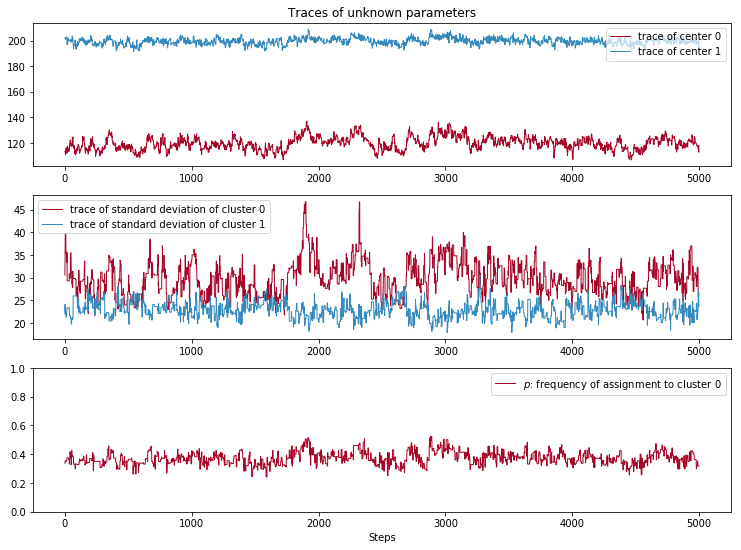

In [0]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

5. Se pueden realizar más iteraciones. 

In [0]:
with model:
    trace = pm.sample(5000, step=[step1], trace=trace)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>BinaryGibbsMetropolis: [assignment]
Sampling 2 chains, 0 divergences: 100%|██████████| 11000/11000 [01:50<00:00, 99.53draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


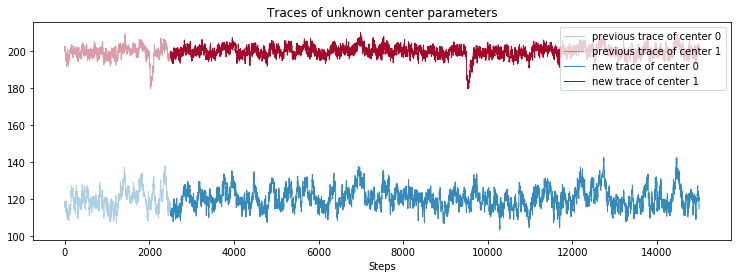

In [0]:
figsize(12.5, 4)
center_trace = trace["centers"][2500:]
prev_center_trace = trace["centers"][:2500]

x = np.arange(2500)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(2500, 15000)
plt.plot(x, center_trace[:, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, center_trace[:, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

3. **Según usted, ¿se logró converger a una solución?**
 - **R:** Si, los centros (especialmente el centro 1) no oscilan demasiado.


4. **Revise el avance de la desviación estándar en la siguiente celda de código, luego conteste si en este caso existe convergencia a una solución**
 - **R:** teniendo una desviación estándar aproximado de 40 y 25 para el *centro 0* y el *centro 1* respectivamente, el cuál no oscila notablemente a excepción de unos pequeños picos.
   Considerando convergencia como 'rondar el punto estable', stv converge

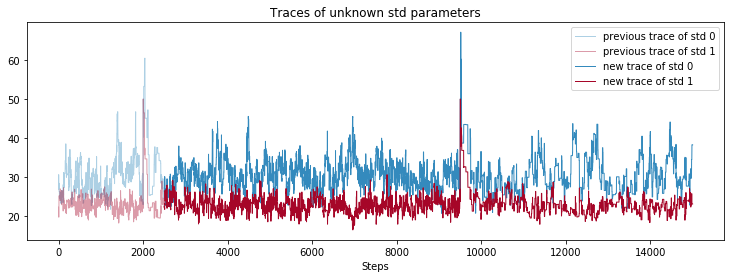

In [0]:
figsize(12.5, 4)
std_trace =  trace["sds"][2500:]
prev_std_trace = trace["sds"][:2500]


x = np.arange(2500)
plt.plot(x, prev_std_trace[:, 0], label="previous trace of std 0",lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_std_trace[:, 1], label="previous trace of std 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(2500, 15000)
plt.plot(x, std_trace[:, 0], label="new trace of std 0", lw=lw, c="#348ABD")
plt.plot(x, std_trace[:, 1], label="new trace of std 1", lw=lw, c="#A60628")

plt.title("Traces of unknown std parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

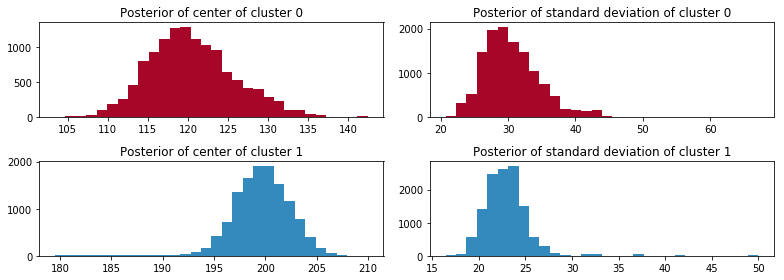

In [0]:
figsize(11.0, 4)
std_trace = trace["sds"][2500:]
prev_std_trace = trace["sds"][:2000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

5. **Cree un gráfico de las distribuciones teóricas de las medias y desviaciones estandar definidas en el inicio del modelamiento.**

In [0]:
import random
import pandas as pd

In [0]:
def getMeans(data):
    N=range(0,len(data),100)
    return [ data[:i].mean() for i in N ]

def getStds(data):
    N=range(0,len(data),100)
    return [ data[:i].std() for i in N ]


[]

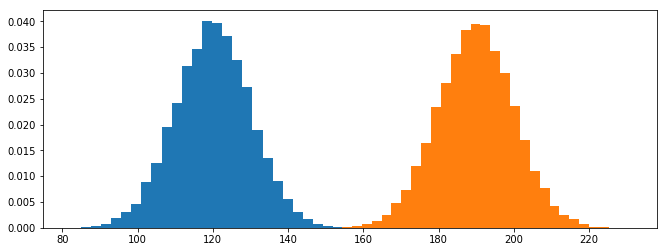

In [0]:
_mu=[120,190]
_stdv=[10,10]
n=20000
_normal=[np.random.normal(_mu[0],_stdv[0],n),np.random.normal(_mu[1],_stdv[1],n)]
data0=pd.Series(data=_normal[0])
data1=pd.Series(data=_normal[1])
data=[data0,data1]


plt.hist(_normal[0], 30, density=True,label='normal 0')
# plt.plot(bins, 1/(_stdv[0] * np.sqrt(2 * np.pi)) *
#                np.exp( - (bins - _mu[0])**2 / (2 * _stdv[0]**2) ),
#          linewidth=2, color='r')
plt.hist(_normal[1], 30, density=True,label='normal 1')
# plt.plot(bins, 1/(_stdv[1] * np.sqrt(2 * np.pi)) *
#                np.exp( - (bins - _mu[1])**2 / (2 * _stdv[1]**2) ),
#          linewidth=2, color='r')
plt.plot()

[]

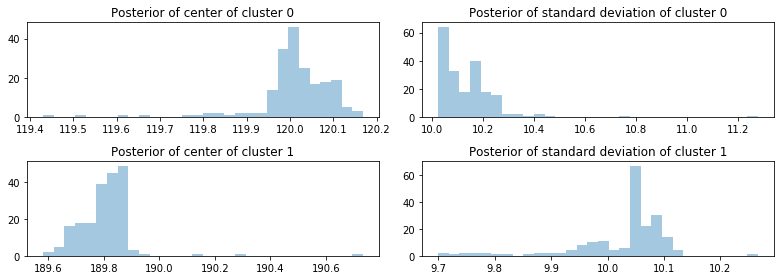

In [0]:

std_trace = trace["sds"][2500:]
prev_std_trace = trace["sds"][:2000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior of center of cluster %d" % i)
#     plt.hist(center_trace[:, i],label='center 0', color=colors[i], bins=30, histtype="stepfilled",alpha=0.4)
    plt.hist(getMeans(data[i]), 30, histtype='stepfilled', alpha=0.4)

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior of standard deviation of cluster %d" % i)
#     plt.hist(std_trace[:, i], color=colors[i], bins=30, histtype="stepfilled")
    plt.hist(getStds(data[i]), 30, histtype='stepfilled', alpha=0.4)

#     plt.autoscale(tight=True)
    
# plt.legend()
plt.tight_layout()
plt.plot()

6. **Compare el gráfico de Posteriors y el suyo ¿Qué concluciones puede inferir de los gráficos expuestos?**



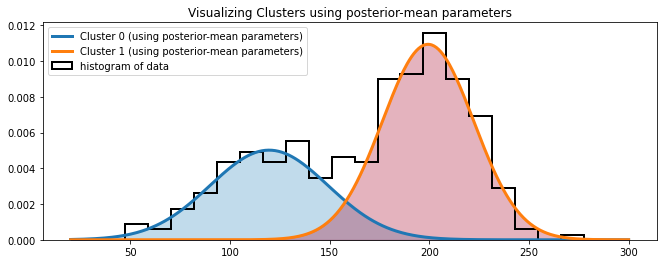

In [0]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", density=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");


7. **Con los mismos datos anteriores, cree un modelo donde defina que existe una solo gaussiana y no dos. Siga todos los pasos anteriores para este nuevo caso y compare los resultados.**

## Referencias y enlaces útiles

- Bayesian Methods for Hackers chap 3: 
https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/Ch3_IntroMCMC_PyMC2.ipynb
- Explicación didáctica de Markov Chain 
   - https://brilliant.org/wiki/markov-chains/
   - https://setosa.io/ev/markov-chains/

- MCMC Libro https://statweb.stanford.edu/~owen/mc/Ch-MCMC.pdf

- Lectura extra https://www.americanscientist.org/article/first-links-in-the-markov-chain

- Hamiltonian Monte Carlo explained http://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html

- Otro ejemplo de MCMC con Gaussian Mixture Models https://docs.pymc.io/notebooks/gaussian_mixture_model.html